# 信用卡交易欺诈检测

## 一、准备数据

下载数据

In [179]:
import os

file_path = 'data/assignment_1.zip'

# 检查文件是否存在
if not os.path.exists(file_path):
    !wget https://filerepo.idzcn.com/dataset/assignment_1.zip -P data
    print("数据文件下载完成。")
else:
    print("数据文件已存在，无需下载。")

数据文件已存在，无需下载。


解压数据

In [180]:
import os
import zipfile

zip_file_path = file_path
extracted_folder_path = 'data/assignment_1'

# 检查解压后的文件夹是否存在
if not os.path.exists(extracted_folder_path):
    # 如果文件夹不存在，则解压文件
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder_path)
    print("数据文件解压完成。")
else:
    print("数据文件已经解压，无需再次解压。")

数据文件已经解压，无需再次解压。


## 二、导入模块（使用oneAPI）

In [181]:
import os
import numpy as np
import warnings

# 导入相关的python模块，忽略 warnings 信息
warnings.filterwarnings("ignore")

# 使用原生pandas
import pandas as pd

# # 使用modin
# # 导入 Modin 库，设置 HDK (Heterogeneous Data Kernels) 作为后端计算引擎，该引擎基于OmniSciDB来获得针对特定dataframe操作集的高单节点可扩展性
# import modin.pandas as pd
# import modin.config as cfg
# cfg.StorageFormat.put('hdk')

# # 导入Intel® Extension for Scikit-learn库，调用patch函数，从而在运行时调用底层 Intel® oneAPI Data Analytics Library 对机器学习算法进行加速
# # 以下两行导入Intel® Extension for Scikit-learn库，调用patch函数加速。如果使用原生的scikit-learn, 注释这两行即可
# from sklearnex import patch_sklearn
# patch_sklearn()

print("导入模块成功")

导入模块成功


## 三、加载数据

查看数据文件大小并加载数据到 dataframe中（如果机器内存有限，请尝试读取部分数据）
- 注：Intel® Distribution of Modin 和 Intel® Extension for Scikit-learn 对数据量比较大的工作负载有较好的加速效果。

In [182]:
import os

data_file_path = "data/assignment_1/creditcard.csv"

def printSize():
    # 检查文件是否存在
    if os.path.exists(data_file_path):
        # 获取文件大小（以字节为单位）
        file_size_bytes = os.path.getsize(data_file_path)
        # 将字节数转换为更友好的格式（GB、MB 或 KB）
        if file_size_bytes < 1024:
            file_size = f"{file_size_bytes} bytes"
        elif file_size_bytes < 1024 * 1024:
            file_size = f"{file_size_bytes / 1024:.2f} KB"
        elif file_size_bytes < 1024 * 1024 * 1024:
            file_size = f"{file_size_bytes / (1024 * 1024):.2f} MB"
        else:
            file_size = f"{file_size_bytes / (1024 * 1024 * 1024):.2f} GB"

        print(f"The size of the file is: {file_size}")
    else:
        print("The file does not exist.")
def loadData():
    import time
    dt_start = time.time()
    # 如果内存足够，使用该行代码读取所有数据
    credit_card_data = pd.read_csv(data_file_path)
    # 如果内存有限，可以只读取部分数据集，如：
    # credit_card_data = pd.read_csv(data_file_path, nrows=5000000)
    print("read_csv time: ", time.time() - dt_start)
    return credit_card_data

print("数据加载函数定义完成")

数据加载函数定义完成


In [183]:
printSize()
credit_card_data = loadData()

The size of the file is: 143.84 MB
read_csv time:  0.9250650405883789


## 四、数据概览与分析

数据说明
- Time：所有交易与第一个交易的时间间隔
  - 数据集中每个事务与第一个事务之间经过的秒数
- V1-V28
  - 是PCA后的特征，因为需要保密，所以不知道原始信息，不清楚数据的具体含义
  - 已经经过了降维处理，因此我们不需要对数据再进行预处理
- Amount：交易金额
- Class即为分类标签，1代表存在欺诈行为，0代表正常交易

In [ ]:
credit_card_data = loadData()

### 1.特征概览

In [184]:
credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [185]:
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [186]:
credit_card_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 2.空值概览

In [187]:
credit_card_data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

没有空值，不需要处理缺失

### 3.分类标签（欺诈交易）的分布

通过柱状图来查看分类标签的分布

Class Counts:
Class
0    284315
1       492
Name: count, dtype: int64


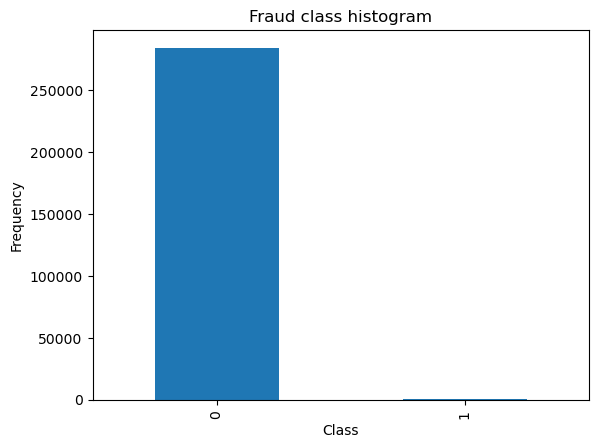

In [188]:
import matplotlib.pyplot as plt
%matplotlib inline

# 计算不同类别的数量
count_classes = credit_card_data['Class'].value_counts(sort=True)

# 输出类别数量
print("Class Counts:")
print(count_classes)

# 计算类别占比
class_percentages = credit_card_data['Class'].value_counts(normalize=True) * 100

# 绘制柱状图
count_classes.plot(kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

可以看到，欺诈交易数量较少(Class=1)，样本分布不均匀，需要进行处理

### 4.分类标签相对于交易时间（Time）的分布

Normal (Class=0): 
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64

Fraud (Class=1): 
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64


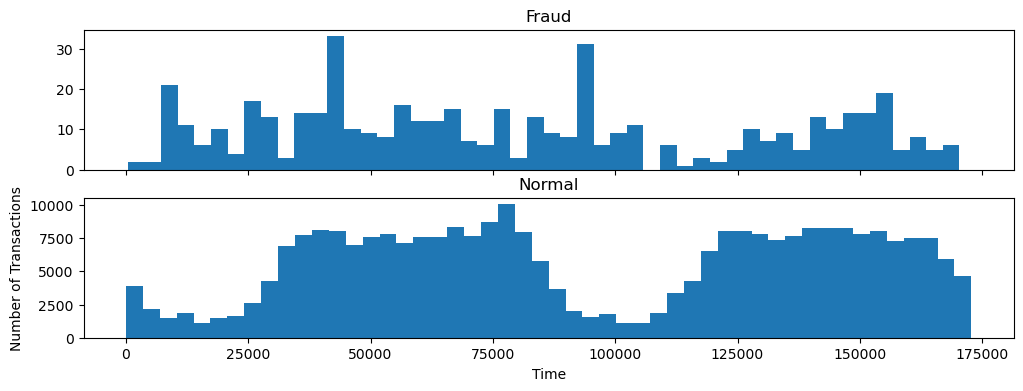

In [189]:
print("Normal (Class=0): ")
print(credit_card_data.Time[credit_card_data.Class == 0].describe())
print("")
print("Fraud (Class=1): ")
print(credit_card_data.Time[credit_card_data.Class == 1].describe())

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))

bins = 50

ax1.hist(credit_card_data.Time[credit_card_data.Class==1], bins=bins)
ax1.set_title("Fraud")

ax2.hist(credit_card_data.Time[credit_card_data.Class==0], bins=bins)
ax2.set_title("Normal")

plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

从Time的description和分布图来看：
- 欺诈交易分布更加均匀
- 正常交易似乎有交易周期
- 在正常交易的交易低频时间段更容易检测到欺诈交易

### 5.分类标签相对于交易金额（Amount）的分布

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


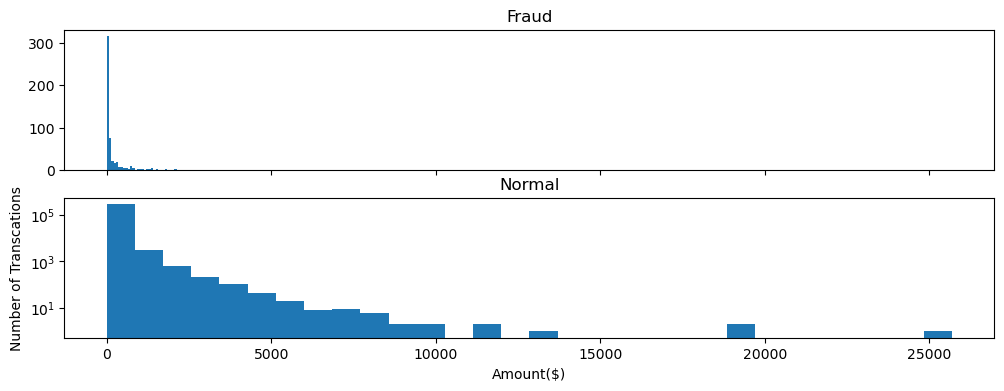

In [190]:
print("Normal")
print(credit_card_data.Amount[credit_card_data.Class==0].describe())
print("")
print("Fraud")
print(credit_card_data.Amount[credit_card_data.Class==1].describe())

f1, (ax3, ax4) = plt.subplots(2, 1, sharex=True, figsize=(12, 4))

bins = 30

ax3.hist(credit_card_data.Amount[credit_card_data.Class==1], bins=bins)
ax3.set_title("Fraud")

ax4.hist(credit_card_data.Amount[credit_card_data.Class==0], bins=bins)
ax4.set_title("Normal")
plt.xlabel("Amount($)")
plt.ylabel("Number of Transcations")
plt.yscale("log")
plt.show()

从Amount的description和分布图来看：
- 在金额上，欺诈交易和正常交易的分布差距较大
- 欺诈交易的金额较小，最大值只有2125.87，而且集中在小金额交易中
- Amount的标准差较大，需要归一化处理

### 6.可能的数据预处理

1. Time可能与是否欺诈没有逻辑上的关系，可能需要去除
2. Amount的标准差较大，需要归一化处理
3. 处理样本不均匀的问题

## 五、定义数据预处理函数

In [ ]:
from sklearn.preprocessing import StandardScaler

### 预处理一：对Amount进行标准化放缩，得到normAmount；对Time进行标准化放缩，得到normTime

In [ ]:
# 预处理一：对Amount进行标准化放缩，得到normAmount；对Time进行标准化放缩，得到normTime
def load_process_split_data1():
    # 读取数据
    data = loadData()
    # 使用标准化放缩对Amount进行归一化处理
    data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
    data = data.drop(['Time','Amount'],axis=1)
    X = data.drop('Class', axis=1)
    y = data['Class']
    # 划分训练集和测试集
    return train_test_split(X, y, test_size=0.2, random_state=42)

### 预处理二：在预处理一的基础上，进行下采样处理 

In [ ]:
def load_process_split_data2():
    data = loadData()
    # 使用标准化放缩对Amount进行归一化处理
    data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
    data = data.drop(['Time','Amount'],axis=1)
    # 下采样解决样本数据不均衡
    fraud_data = data[data['Class'] == 1]
    normal_data = data[data['Class'] == 0].sample(n=len(fraud_data), random_state=42)
    balanced_data = pd.concat([fraud_data, normal_data])
    # 划分特征和标签
    X = balanced_data.drop('Class', axis=1)
    y = balanced_data['Class']
    # 划分训练集和测试集
    return train_test_split(X, y, test_size=0.2, random_state=42)

### 预处理三：在预处理一的基础上，进行过采样处理

In [ ]:
# %pip install imbalanced-learn
def load_process_split_data3():
    data = loadData()
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, average_precision_score
    # 使用标准化放缩对Amount进行归一化处理
    data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
    data = data.drop(['Time','Amount'],axis=1)
    X = data.drop('Class', axis=1)
    y = data['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    # 使用SMOTE进行过采样
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

## 六、定义模型训练函数

### 逻辑回归分类

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# 使用逻辑回归模型进行训练
# return f1, auprc, train_time, inference_time
def train_with_LogisticRegression(load_process_split_data):
    X_train, X_test, y_train, y_test = load_process_split_data()
    # 特征缩放
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # 使用逻辑回归模型进行训练
    import time
    dt_start = time.time()
    model = LogisticRegression()
    model.fit(X_train, y_train)
    train_time = time.time() - dt_start
    # 预测
    import time
    start_time = time.time()
    y_pred = model.predict(X_test)
    # 预测概率
    y_prob = model.predict_proba(X_test)[:, 1]
    # 寻找最佳阈值
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    optimal_threshold = thresholds[np.argmax(tpr - fpr)]
    # 使用最佳阈值重新进行预测
    y_pred_optimal = (y_prob > optimal_threshold).astype(int)
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    # 计算概率并绘制精确率-召回率曲线
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    auprc = auc(recall, precision)
    # 计算 F1 分数
    f1 = f1_score(y_test, y_pred)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 逻辑回归模型+网格搜索

In [312]:
from sklearn.model_selection import GridSearchCV

def train_with_LogisticRegression_gird_search(load_process_split_data):
    X_train, X_test, y_train, y_test = load_process_split_data()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # 定义参数网格
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2']
    }
    
    # 创建逻辑回归模型
    lr_model = LogisticRegression()
    
    # 创建网格搜索对象
    grid_search = GridSearchCV(lr_model, param_grid, cv=5)
    
    # 在训练集上进行网格搜索
    import time
    dt_start = time.time()
    grid_search.fit(X_train, y_train)
    
    # 获取最佳参数组合
    best_params = grid_search.best_params_
    
    # 使用最佳参数创建逻辑回归模型
    lr_model_best = LogisticRegression(**best_params)
    
    # 训练模型
    lr_model_best.fit(X_train, y_train)
    train_time = time.time() - dt_start
    # 预测测试集
    start_time = time.time()
    y_pred = lr_model_best.predict(X_test)
    inference_time = time.time() - start_time
    # 计算概率并绘制精确率-召回率曲线
    y_prob = lr_model_best.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    auprc = auc(recall, precision)

    # 计算 F1 分数
    f1 = f1_score(y_test, y_pred)

    # 打印结果
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 逻辑回归模型+k折交叉验证

In [253]:

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

# 使用k折交叉验证，使用逻辑回归模型进行训练
# return f1, auprc, train_time, inference_time
def train_with_LogisticRegression_k_fold(load_process_split_data):
    X_train, X_test, y_train, y_test = load_process_split_data()
    # 归一化处理
    X_train_norm = (X_train - X_train.mean()) / X_train.std()
    X_test_norm = (X_test - X_train.mean()) / X_train.std()
    # 使用k折交叉验证寻找最优惩罚参数
    import time
    dt_start = time.time()
    penalty_params = [0.01, 0.1, 1, 10, 100]
    best_f1_score = 0
    best_penalty_param = None

    for penalty_param in penalty_params:
        f1_scores = []
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        for train_index, val_index in skf.split(X_train_norm, y_train):
            X_train_fold, X_val_fold = X_train_norm.iloc[train_index], X_train_norm.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # 训练逻辑回归模型
            model = LogisticRegression(penalty='l2', C=1/penalty_param, random_state=42)
            model.fit(X_train_fold, y_train_fold)

            # 预测验证集
            y_val_pred = model.predict(X_val_fold)

            # 计算F1分数
            f1_scores.append(f1_score(y_val_fold, y_val_pred))

        avg_f1_score = np.mean(f1_scores)

        # 更新最优参数
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_penalty_param = penalty_param
        
    train_time = time.time() - dt_start

    # 在测试集上评估模型
    import time
    start_time = time.time()
    model = LogisticRegression(penalty='l2', C=1/best_penalty_param, random_state=42)
    model.fit(X_train_norm, y_train)
    y_test_pred = model.predict(X_test_norm)
    inference_time = time.time() - start_time

    # 计算F1分数
    f1 = f1_score(y_test, y_test_pred)

    # 计算精确率-召回率曲线下面积
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    auprc = auc(recall, precision)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 决策树分类

In [306]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc

def train_with_DecisionTreeClassifier(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    import time
    dt_start = time.time()
    # 创建决策树模型
    dt_model = DecisionTreeClassifier(random_state=42)
    # 训练模型
    dt_model.fit(X_train, y_train)
    train_time = time.time() - dt_start
    import time
    start_time = time.time()
    # 预测测试集
    y_pred = dt_model.predict(X_test)
    inference_time = time.time() - start_time
    # 评估模型
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auprc = auc(recall, precision)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 决策树分类+网格搜索

In [310]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc

def train_with_DecisionTreeClassifier_grid_search(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    
    # 定义参数网格
    param_grid = {
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # 创建决策树模型
    dt_model = DecisionTreeClassifier(random_state=42)
    
    # 创建网格搜索对象
    grid_search = GridSearchCV(dt_model, param_grid, cv=5)
    
    # 在训练集上进行网格搜索
    import time
    dt_start = time.time()
    grid_search.fit(X_train, y_train)
    
    # 获取最佳参数组合
    best_params = grid_search.best_params_
    
    # 使用最佳参数创建决策树模型
    dt_model_best = DecisionTreeClassifier(random_state=42, **best_params)
    
    # 训练模型
    dt_model_best.fit(X_train, y_train)
    train_time = time.time() - dt_start

    # 预测测试集
    import time
    start_time = time.time()
    y_pred = dt_model_best.predict(X_test)
    idference_time = time.time() - start_time

    # 评估模型
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auprc = auc(recall, precision)
    
    # 打印结果
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 决策树分类+k折交叉验证

In [313]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc

def train_with_DecisionTreeClassifier_k_fold(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    # 归一化处理
    X_train_norm = (X_train - X_train.mean()) / X_train.std()
    X_test_norm = (X_test - X_train.mean()) / X_train.std()

    # 使用k折交叉验证寻找最优参数
    import time
    dt_start = time.time()
    max_depth_params = [None, 5, 10, 15, 20]
    best_f1_score = 0
    best_max_depth = None

    for max_depth_param in max_depth_params:
        f1_scores = []
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

        for train_index, val_index in skf.split(X_train_norm, y_train):
            X_train_fold, X_val_fold = X_train_norm.iloc[train_index], X_train_norm.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # 创建决策树模型
            dt_model = DecisionTreeClassifier(max_depth=max_depth_param, random_state=42)

            # 训练模型
            dt_model.fit(X_train_fold, y_train_fold)

            # 预测验证集
            y_val_pred = dt_model.predict(X_val_fold)

            # 计算F1分数
            f1_scores.append(f1_score(y_val_fold, y_val_pred))

        avg_f1_score = np.mean(f1_scores)

        # 更新最优参数
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_max_depth = max_depth_param
        
    train_time = time.time() - dt_start

    # 在测试集上评估模型
    import time
    start_time = time.time()
    model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
    model.fit(X_train_norm, y_train)
    y_test_pred = model.predict(X_test_norm)
    inference_time = time.time() - start_time

    # 计算F1分数
    f1 = f1_score(y_test, y_test_pred)

    # 计算精确率-召回率曲线下面积
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
    auprc = auc(recall, precision)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 随机森林

In [254]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc

def train_with_RandomForestClassifier(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    import time
    dt_start = time.time()
    # 创建随机森林模型
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    # 训练模型
    rf_model.fit(X_train, y_train)
    train_time = time.time() - dt_start
    import time
    start_time = time.time()
    # 预测测试集
    y_pred = rf_model.predict(X_test)
    inference_time = time.time() - start_time
    # 评估模型
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auprc = auc(recall, precision)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 随机森林+网格搜索

In [316]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, auc

def train_with_RandomForestClassifier_grid_search(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()

    # 定义参数网格
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # 创建随机森林模型
    rf_model = RandomForestClassifier(random_state=42)

    # 创建网格搜索对象
    grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1')

    # 在训练集上进行网格搜索
    import time
    dt_start = time.time()
    grid_search.fit(X_train, y_train)

    # 获取最佳参数组合
    best_params = grid_search.best_params_

    # 使用最佳参数创建随机森林模型
    rf_model_best = RandomForestClassifier(**best_params, random_state=42)

    # 在整个训练集上训练模型
    rf_model_best.fit(X_train, y_train)

    train_time = time.time() - dt_start

    # 预测测试集
    import time
    start_time = time.time()
    y_pred = rf_model_best.predict(X_test)
    inference_time = time.time() - start_time

    # 评估模型
    f1 = f1_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auprc = auc(recall, precision)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    
    return f1, auprc, train_time, inference_time

### 支持向量机

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, average_precision_score

def train_with_SVC(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    # 数据归一化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 使用支持向量机进行建模
    svm_model = SVC(kernel='linear', C=1.0, random_state=42)

    import time
    start_time = time.time()
    svm_model.fit(X_train_scaled, y_train)
    inference_time = time.time() - start_time

    # 在测试集上进行预测
    y_pred = svm_model.predict(X_test_scaled)

    # 计算F1分数
    f1 = f1_score(y_test, y_pred)

    # 计算AUPRC
    auprc = average_precision_score(y_test, y_pred)
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", 0)
    print("Inference time: ", inference_time)
    return f1, auprc, 0, inference_time

### 神经网络

In [288]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader  # Import TensorDataset and DataLoader
from sklearn.metrics import f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 定义神经网络模型
class FraudDetectionModel(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

def train_with_nn(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()

    # 转换为PyTorch的Tensor格式
    X_train = torch.Tensor(X_train.values)
    y_train = torch.Tensor(y_train.values)  # 将y_train转换为NumPy数组
    X_test = torch.Tensor(X_test.values)
    y_test = torch.Tensor(y_test.values)  # 将y_test转换为NumPy数组

    # 定义训练数据集
    train_dataset = TensorDataset(X_train, y_train)  # Use TensorDataset
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Use DataLoader

    # 初始化模型
    model = FraudDetectionModel(input_dim=X_train.shape[1])

    # 定义损失函数和优化器
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练模型
    import time
    dt_start = time.time()
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()
    train_time = time.time() - dt_start
    # 在测试集上进行预测
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = y_pred.squeeze().numpy()

    # 根据预测结果计算评估指标
    import time
    start_time = time.time()
    f1 = f1_score(y_test, y_pred.round())  # y_test已经是NumPy数组，无需再转换
    auprc = average_precision_score(y_test, y_pred)  # y_test已经是NumPy数组，无需再转换
    inference_time = time.time() - start_time
    print("F1 score: ", f1)
    print("AUPRC score: ", auprc)
    print("Train time: ", train_time)
    print("Inference time: ", inference_time)
    return f1, auprc, train_time, inference_time

### 梯度提升树xgboost

In [257]:
import xgboost as xgb
from sklearn.metrics import f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_with_xgboost(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    # Create the XGBoost classifier
    model = xgb.XGBClassifier()

    # Train the model
    import time
    dt_start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - dt_start

    # Predict on the test set
    import time
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred)

    print("F1 score:", f1)
    print("AUPRC:", auprc)
    print("Inference time:", inference_time, "seconds")
    print("Train time:", train_time, "seconds")
    return f1, auprc, train_time, inference_time

### 梯度提升树LightGBM

In [ ]:
%pip install lightgbm

In [258]:
import lightgbm as lgb
from sklearn.metrics import f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_with_lightgbm(load_process_split_data):
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = load_process_split_data()
    # 创建LightGBM分类器
    model = lgb.LGBMClassifier()

    # 训练模型
    import time
    dt_start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - dt_start

    # 在测试集上进行预测
    import time
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    # 计算评估指标
    f1 = f1_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_pred)
    print("F1 score:", f1)
    print("AUPRC:", auprc)
    print("Inference time:", inference_time, "seconds")
    print("Train time:", train_time, "seconds")
    return f1, auprc, train_time, inference_time

## 七、训练与测试

### 定义测试保存函数

In [249]:
def train_and_save_results(model_name, train_function, data_function):
    results = {}
    f1, auprc, train_time, inference_time = train_function(data_function)
    results[model_name] = {
        "f1": f1,
        "auprc": auprc,
        "train_time": train_time,
        "inference_time": inference_time
    }
    return results

results = {}

### 逻辑回归模型

In [278]:
# 基础逻辑回归模型
results.update(
    train_and_save_results(
        "基础逻辑回归模型", 
        train_with_LogisticRegression, 
        load_process_split_data1
        )
    )
# 下采样+逻辑回归模型
results.update(
    train_and_save_results(
        "下采样+逻辑回归模型", 
        train_with_LogisticRegression, 
        load_process_split_data2
        )
    )
# 过采样+逻辑回归模型
results.update(
    train_and_save_results(
        "过采样+逻辑回归模型", 
        train_with_LogisticRegression, 
        load_process_split_data3
        )
    )

read_csv time:  0.9017317295074463
F1 score:  0.6951219512195121
AUPRC score:  0.7597700821604859
Train time:  0.5295991897583008
Inference time:  0.011732101440429688
read_csv time:  0.8227641582489014
F1 score:  0.9578947368421054
AUPRC score:  0.9950651804437555
Train time:  0.0039997100830078125
Inference time:  0.0009996891021728516
read_csv time:  0.863872766494751
F1 score:  0.10982306284319707
AUPRC score:  0.7705618323203829
Train time:  2.10446834564209
Inference time:  0.01176762580871582


### 逻辑回归模型+网格搜索

In [314]:
# 逻辑回归模型+网格搜索
results.update(
    train_and_save_results(
        "逻辑回归模型+网格搜索", 
        train_with_LogisticRegression_gird_search, 
        load_process_split_data1
        )
    )
# 下采样+逻辑回归模型+网格搜索
results.update(
    train_and_save_results(
        "下采样+逻辑回归模型+网格搜索", 
        train_with_LogisticRegression_gird_search, 
        load_process_split_data2
        )
    )
# 过采样+逻辑回归模型+网格搜索
results.update(
    train_and_save_results(
        "过采样+逻辑回归模型+网格搜索", 
        train_with_LogisticRegression_gird_search, 
        load_process_split_data3
        )
    )

read_csv time:  0.7940385341644287
F1 score:  0.6951219512195121
AUPRC score:  0.7595340829893636
Train time:  8.044172048568726
Inference time:  0.003048419952392578
read_csv time:  0.8886873722076416
F1 score:  0.9637305699481866
AUPRC score:  0.9951849296969525
Train time:  0.09838247299194336
Inference time:  0.0
read_csv time:  0.7833354473114014
F1 score:  0.1094890510948905
AUPRC score:  0.770524570622362
Train time:  27.49867820739746
Inference time:  0.0030002593994140625


### 逻辑回归模型+k折验证

In [260]:
# 基础逻辑回归模型+k折验证
results.update(
    train_and_save_results(
        "基础逻辑回归模型+k折验证", 
        train_with_LogisticRegression_k_fold, 
        load_process_split_data1
        )
    )
# 下采样+逻辑回归模型+k折验证
results.update(
    train_and_save_results(
        "下采样+逻辑回归模型+k折验证", 
        train_with_LogisticRegression_k_fold, 
        load_process_split_data2
        )
    )
# 过采样+逻辑回归模型+k折验证
results.update(
    train_and_save_results(
        "过采样+逻辑回归模型+k折验证", 
        train_with_LogisticRegression_k_fold, 
        load_process_split_data3
        )
    )

read_csv time:  0.8495981693267822
F1 score:  0.6871165644171779
AUPRC score:  0.7168521833140351
Train time:  12.893155574798584
Inference time:  0.6055986881256104
read_csv time:  0.9803345203399658
F1 score:  0.9637305699481866
AUPRC score:  0.9796062471567387
Train time:  0.17008543014526367
Inference time:  0.007692813873291016
read_csv time:  1.0063657760620117
F1 score:  0.10962241169305724
AUPRC score:  0.48839897344302713
Train time:  42.873607873916626
Inference time:  2.2102458477020264


### 决策树

In [307]:
# 基础决策树模型
results.update(
    train_and_save_results(
        "基础决策树模型", 
        train_with_DecisionTreeClassifier, 
        load_process_split_data1
        )
    )
# 下采样+决策树模型
results.update(
    train_and_save_results(
        "下采样+决策树模型", 
        train_with_DecisionTreeClassifier, 
        load_process_split_data2
        )
    )
# 过采样+决策树模型
results.update(
    train_and_save_results(
        "过采样+决策树模型", 
        train_with_DecisionTreeClassifier, 
        load_process_split_data3
        )
    )

read_csv time:  0.879859447479248
F1 score:  0.7378640776699029
AUPRC score:  0.7398000650896064
Train time:  16.989458799362183
Inference time:  0.008697748184204102
read_csv time:  0.8524999618530273
F1 score:  0.9035532994923858
AUPRC score:  0.9289572928079093
Train time:  0.019739389419555664
Inference time:  0.0005059242248535156
read_csv time:  0.8505802154541016
F1 score:  0.5357142857142857
AUPRC score:  0.5888989062470631
Train time:  38.798930168151855
Inference time:  0.009667396545410156


### 决策树+网格搜索

In [311]:
# 基础决策树模型+网格搜索
results.update(
    train_and_save_results(
        "基础决策树模型+网格搜索", 
        train_with_DecisionTreeClassifier_grid_search, 
        load_process_split_data1
        )
    )
# 下采样+决策树模型+网格搜索
results.update(
    train_and_save_results(
        "下采样+决策树模型+网格搜索", 
        train_with_DecisionTreeClassifier_grid_search, 
        load_process_split_data2
        )
    )
# 过采样+决策树模型+网格搜索
results.update(
    train_and_save_results(
        "过采样+决策树模型+网格搜索", 
        train_with_DecisionTreeClassifier_grid_search, 
        load_process_split_data3
        )
    )

read_csv time:  0.7550427913665771
F1 score:  0.8415300546448088
AUPRC score:  0.8459826527429903
Train time:  555.2025508880615
Inference time:  0.022310972213745117
read_csv time:  0.8310427665710449
F1 score:  0.9361702127659574
AUPRC score:  0.9667452486422429
Train time:  1.330204725265503
Inference time:  0.022310972213745117
read_csv time:  0.807854413986206
F1 score:  0.0903225806451613
AUPRC score:  0.45253086689064415
Train time:  1104.4552142620087
Inference time:  0.022310972213745117


### 决策树+k折验证

In [315]:
# 基础决策树模型+k折验证
results.update(
    train_and_save_results(
        "基础决策树模型+k折验证", 
        train_with_DecisionTreeClassifier_k_fold, 
        load_process_split_data1
        )
    )
# 下采样+决策树模型+k折验证
results.update(
    train_and_save_results(
        "下采样+决策树模型+k折验证", 
        train_with_DecisionTreeClassifier_k_fold, 
        load_process_split_data2
        )
    )
# 过采样+决策树模型+k折验证
results.update(
    train_and_save_results(
        "过采样+决策树模型+k折验证", 
        train_with_DecisionTreeClassifier_k_fold, 
        load_process_split_data3
        )
    )

read_csv time:  0.7883963584899902
F1 score:  0.8415300546448088
AUPRC score:  0.8459826527429903
Train time:  234.92184114456177
Inference time:  4.852327585220337
read_csv time:  0.7840061187744141
F1 score:  0.9255319148936169
AUPRC score:  0.9586148371296378
Train time:  0.37901902198791504
Inference time:  0.012511014938354492
read_csv time:  0.7542078495025635
F1 score:  0.5357142857142857
AUPRC score:  0.5888989062470631
Train time:  450.21998929977417
Inference time:  34.44846844673157


### 随机森林

In [261]:
# 基础随机森林模型
results.update(
    train_and_save_results(
        "基础随机森林模型", 
        train_with_RandomForestClassifier, 
        load_process_split_data1
        )
    )
# 下采样+随机森林模型
results.update(
    train_and_save_results(
        "下采样+随机森林模型", 
        train_with_RandomForestClassifier, 
        load_process_split_data2
        )
    )
# 过采样+随机森林模型
results.update(
    train_and_save_results(
        "过采样+随机森林模型", 
        train_with_RandomForestClassifier, 
        load_process_split_data3
        )
    )

read_csv time:  0.836529016494751
F1 score:  0.8571428571428571
AUPRC score:  0.8698679372160941
Train time:  231.25006008148193
Inference time:  0.33933568000793457
read_csv time:  1.0831389427185059
F1 score:  0.9578947368421054
AUPRC score:  0.9799005281238784
Train time:  0.2829105854034424
Inference time:  0.007007598876953125
read_csv time:  0.9252314567565918
F1 score:  0.875
AUPRC score:  0.8755028281532325
Train time:  392.8038651943207
Inference time:  0.3669261932373047


### 支持向量机

In [281]:
# 基础SVM模型
results.update(
    train_and_save_results(
        "基础SVM模型", 
        train_with_SVC, 
        load_process_split_data1
        )
    )
# 下采样+SVM模型
results.update(
    train_and_save_results(
        "下采样+SVM模型", 
        train_with_SVC, 
        load_process_split_data2
        )
    )
# 过采样+SVM模型
results.update(
    train_and_save_results(
        "过采样+SVM模型", 
        train_with_SVC, 
        load_process_split_data3
        )
    )

read_csv time:  0.8365156650543213
F1 score:  0.8020833333333333
AUPRC score:  0.6439856881071143
Train time:  0
Inference time:  597.7811634540558
read_csv time:  0.8061943054199219
F1 score:  0.9411764705882353
AUPRC score:  0.9447264523406655
Train time:  0
Inference time:  0.0059969425201416016
read_csv time:  0.8318102359771729
F1 score:  0.11292346298619824
AUPRC score:  0.055389816983127456
Train time:  0
Inference time:  6336.1060473918915


### 神经网络

In [289]:
# 基础神经网络模型
results.update(
    train_and_save_results(
        "基础神经网络模型", 
        train_with_nn, 
        load_process_split_data1
        )
    )
# 下采样+神经网络模型
results.update(
    train_and_save_results(
        "下采样+神经网络模型", 
        train_with_nn, 
        load_process_split_data2
        )
    )
# 过采样+神经网络模型
results.update(
    train_and_save_results(
        "过采样+神经网络模型", 
        train_with_nn, 
        load_process_split_data3
        )
    )

read_csv time:  0.7502434253692627
F1 score:  0.7885714285714286
AUPRC score:  0.8459342431345601
Train time:  43.164756059646606
Inference time:  0.020882844924926758
read_csv time:  0.8108670711517334
F1 score:  0.9583333333333333
AUPRC score:  0.9928465141420459
Train time:  0.14744901657104492
Inference time:  0.0025060176849365234
read_csv time:  0.8510441780090332
F1 score:  0.6744186046511628
AUPRC score:  0.7233498949991317
Train time:  88.98365926742554
Inference time:  0.01691126823425293


### 梯度提升树xgboost

In [286]:
# 基础XGBoost模型
results.update(
    train_and_save_results(
        "基础XGBoost模型", 
        train_with_xgboost, 
        load_process_split_data1
        )
    )
# 下采样+XGBoost模型
results.update(
    train_and_save_results(
        "下采样+XGBoost模型", 
        train_with_xgboost, 
        load_process_split_data2
        )
    )
# 过采样+XGBoost模型
results.update(
    train_and_save_results(
        "过采样+XGBoost模型", 
        train_with_xgboost, 
        load_process_split_data3
        )
    )

read_csv time:  0.9003658294677734
F1 score: 0.88268156424581
AUPRC: 0.7865517466838983
Inference time: 0.02037358283996582 seconds
Train time: 7.36703634262085 seconds
read_csv time:  0.8718090057373047
F1 score: 0.9583333333333333
AUPRC: 0.9548335271276158
Inference time: 0.002508878707885742 seconds
Train time: 0.04793047904968262 seconds
read_csv time:  0.8121399879455566
F1 score: 0.8133971291866028
AUPRC: 0.6644128150796756
Inference time: 0.020749330520629883 seconds
Train time: 21.18551754951477 seconds


### 梯度提升树LightGBM

In [287]:
# 基础LightGBM模型
results.update(
    train_and_save_results(
        "基础LightGBM模型", 
        train_with_lightgbm, 
        load_process_split_data1
        )
    )
# 下采样+LightGBM模型
results.update(
    train_and_save_results(
        "下采样+LightGBM模型", 
        train_with_lightgbm, 
        load_process_split_data2
        )
    )
# 过采样+LightGBM模型
results.update(
    train_and_save_results(
        "过采样+LightGBM模型", 
        train_with_lightgbm, 
        load_process_split_data3
        )
    )

read_csv time:  0.7506682872772217
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
F1 score: 0.2880658436213992
AUPRC: 0.08731289704327992
Inference time: 0.02363133430480957 seconds
Train time: 0.4197549819946289 seconds
read_csv time:  0.8002173900604248
[LightGBM] [Info] Number of positive: 393, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7394
[LightGBM] [Info] Number of data p

## 八、结果比较与分析

### 定义绘图函数

In [304]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimSun'

def plot_auprc_scores(results):
    model_names = results.keys()
    f1_scores = [result['auprc'] for result in results.values()]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, f1_scores)
    plt.xlabel('Model')
    plt.ylabel('auprc Score')
    plt.title('Comparison of auprc Scores for Different Models')
    plt.xticks(rotation=90)

    for bar, score in zip(bars, f1_scores):
        plt.annotate(f'{score:.5f}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

    plt.show()

def plot_f1_scores(results):
    model_names = results.keys()
    f1_scores = [result['f1'] for result in results.values()]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, f1_scores)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('Comparison of F1 Scores for Different Models')
    plt.xticks(rotation=90)

    for bar, score in zip(bars, f1_scores):
        plt.annotate(f'{score:.5f}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

    plt.show()

def plot_time_performance(results):
    model_names = list(results.keys())
    train_times = [result['train_time'] for result in results.values()]
    inference_times = [result['inference_time'] for result in results.values()]

    # 绘制推理时间和训练时间在一张图上
    plt.figure(figsize=(12, 6))
    plt.plot(model_names, train_times, marker='o', label='Training Time')
    plt.plot(model_names, inference_times, marker='o', label='Inference Time')
    plt.xlabel('Model')
    plt.ylabel('Time (seconds)')
    plt.title('Comparison of Training and Inference Times for Different Models')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

    # 绘制推理时间和训练时间分别在两张图上
    plt.figure(figsize=(12, 6))

    # 绘制训练时间折线图
    plt.subplot(2, 1, 1)
    plt.plot(model_names, train_times, marker='o')
    plt.xlabel('Model')
    plt.ylabel('Training Time (seconds)')
    plt.title('Comparison of Training Times for Different Models')
    plt.xticks(rotation=90)
    for i, time in enumerate(train_times):
        plt.text(i, time, f'{time:.2f}', ha='center', va='bottom')

    # 绘制推理时间折线图
    plt.subplot(2, 1, 2)
    plt.plot(model_names, inference_times, marker='o')
    plt.xlabel('Model')
    plt.ylabel('Inference Time (seconds)')
    plt.title('Comparison of Inference Times for Different Models')
    plt.xticks(rotation=90)
    for i, time in enumerate(inference_times):
        plt.text(i, time, f'{time:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

### 清理重复数据

In [321]:
def clean_duplicate_models(results):
    cleaned_results = {}

    for model_name, model_result in results.items():
        if model_name not in cleaned_results:
            cleaned_results[model_name] = model_result

    return cleaned_results

cleaned_results = clean_duplicate_models(results)

### 绘图

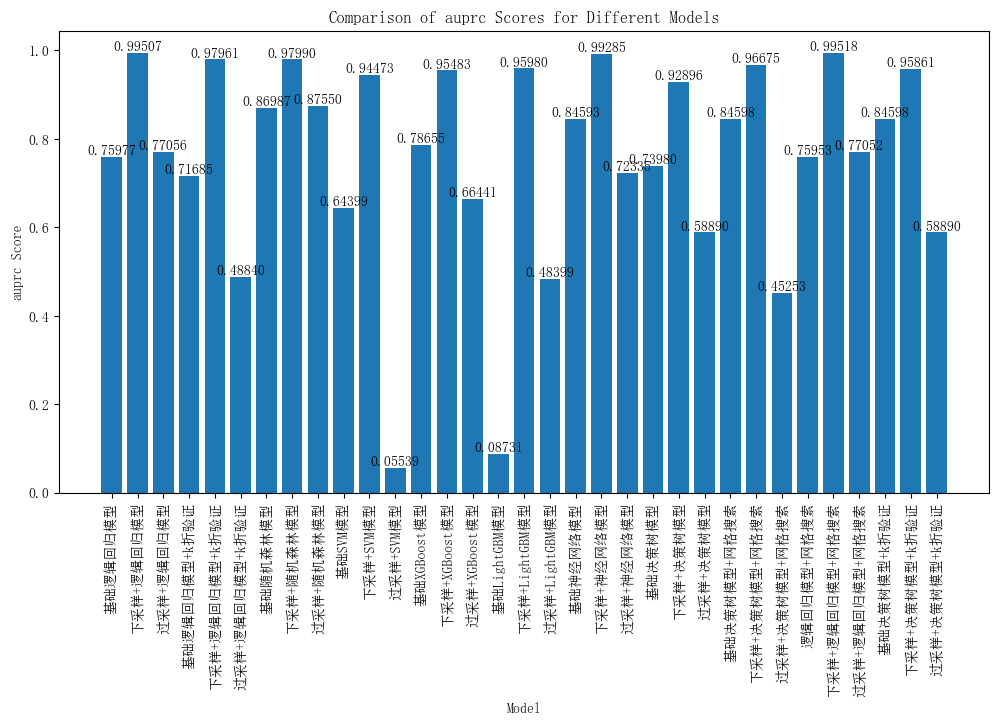

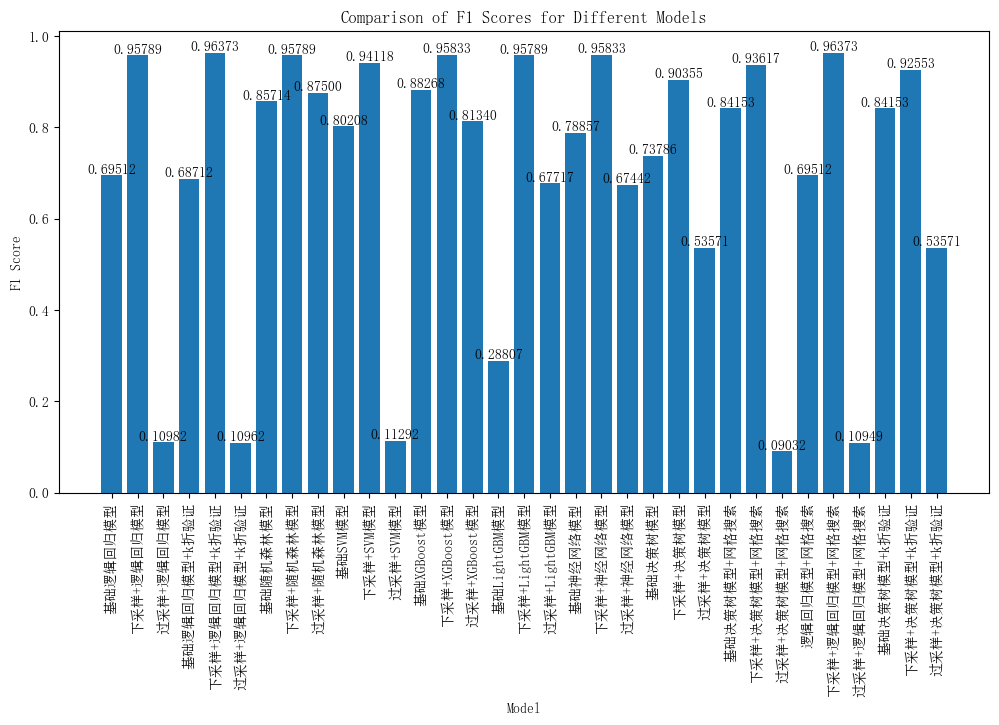

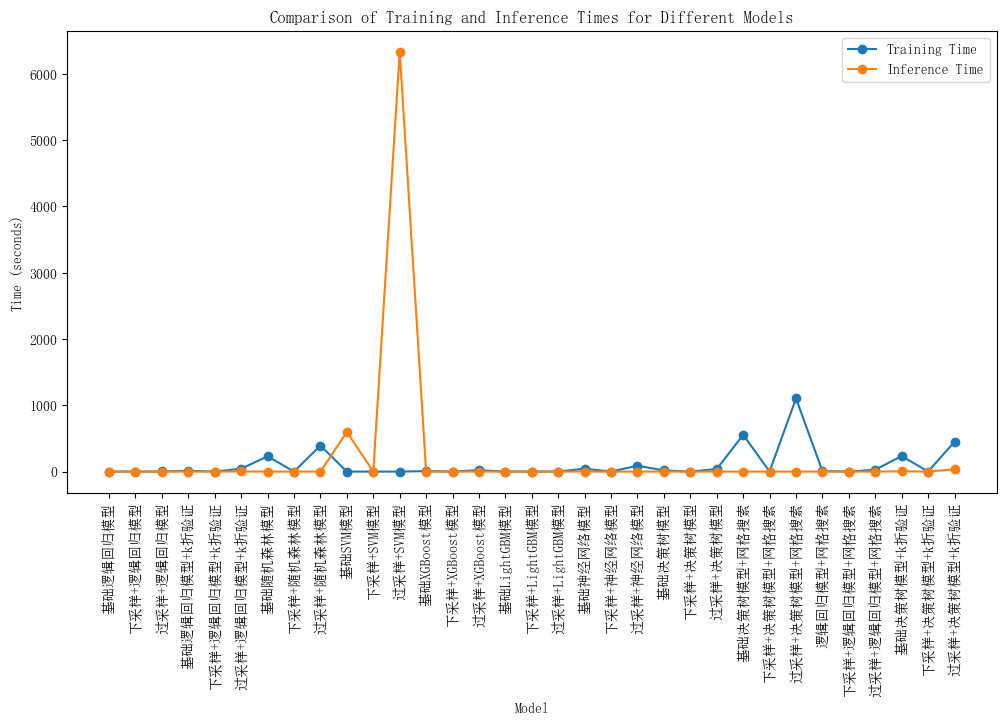

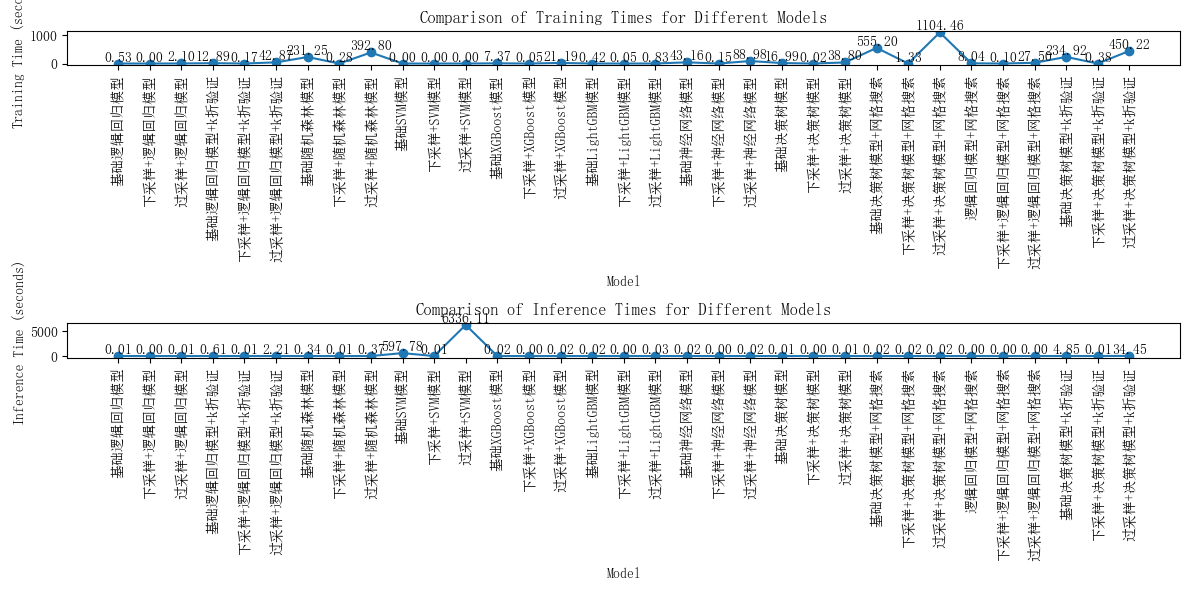

In [322]:
# 绘制AUPRC值比较的柱状图
plot_auprc_scores(cleaned_results)

# 绘制F1值比较的柱状图
plot_f1_scores(cleaned_results)

# 绘制训练时间和推理时间比较的折线图
plot_time_performance(cleaned_results)

In [302]:
%pip install tabulate 

Note: you may need to restart the kernel to use updated packages.


In [323]:
from tabulate import tabulate

# 将 results 转换为表格
df = pd.DataFrame.from_dict(cleaned_results, orient='index')

# 格式化输出表格
table = tabulate(df, headers='keys', tablefmt='psql')

# 显示格式化后的表格
print(table)

+------------------------------+-----------+-----------+---------------+------------------+
|                              |        f1 |     auprc |    train_time |   inference_time |
|------------------------------+-----------+-----------+---------------+------------------|
| 基础逻辑回归模型             | 0.695122  | 0.75977   |    0.529599   |      0.0117321   |
| 下采样+逻辑回归模型          | 0.957895  | 0.995065  |    0.00399971 |      0.000999689 |
| 过采样+逻辑回归模型          | 0.109823  | 0.770562  |    2.10447    |      0.0117676   |
| 基础逻辑回归模型+k折验证     | 0.687117  | 0.716852  |   12.8932     |      0.605599    |
| 下采样+逻辑回归模型+k折验证  | 0.963731  | 0.979606  |    0.170085   |      0.00769281  |
| 过采样+逻辑回归模型+k折验证  | 0.109622  | 0.488399  |   42.8736     |      2.21025     |
| 基础随机森林模型             | 0.857143  | 0.869868  |  231.25       |      0.339336    |
| 下采样+随机森林模型          | 0.957895  | 0.979901  |    0.282911   |      0.0070076   |
| 过采样+随机森林模型          | 0.875     | 0.875503  |  392.804      |   